<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMClassifier</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Обзор данных

In [21]:
import numpy as np
import pandas as pd

import re

import nltk

nltk.download('averaged_perceptron_tagger')
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
tqdm.pandas()


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv')
pd.set_option('display.max_rows', None)#параметр для выводы всего датафрейма
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
def inf(data):
    print(f'Размер датасета - {data.shape}')
    print()
    print('Информация о данных:')
    print(data.info())
    print()
    print(f'Количество пропусков в датасете: {data.isna().sum().sum()}')
    print(f'Указание на пропуски в датасете: {data.isna().sum()}')
    print(f'Дубликаты в датасете: {data.duplicated().sum()}')

In [5]:
inf(data)

Размер датасета - (159292, 3)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None

Количество пропусков в датасете: 0
Указание на пропуски в датасете: Unnamed: 0    0
text          0
toxic         0
dtype: int64
Дубликаты в датасете: 0


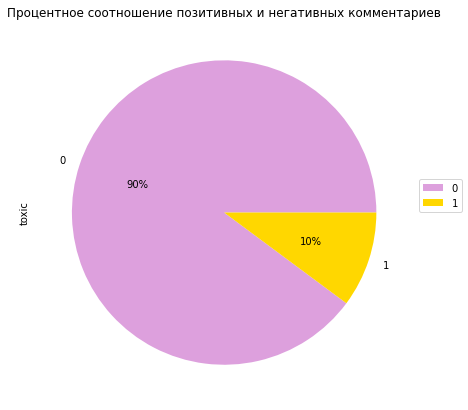

In [6]:
data['toxic'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors = ( "plum","gold"),figsize=(7,7),
                                       title = 'Процентное соотношение позитивных и негативных комментариев')
plt.legend(bbox_to_anchor=(1, 0.6));

**Вывод по первому пункту:**

- В таблице 159 292 объектов,
- Пропусков нет, явных дубликатов нет,
- Тексты комментариев на английском,
- Процентное соотношение позитивных и негативных комментариев показывает, что комментариев класса '0' в 9 раз больше комментариев класса '1'

## Подготовка данных

**Проведем очистку и лемматизацию текста**

In [7]:
def clear_text(text):
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    return ' '.join(text.split())

In [8]:
def lemmatize(text):
    m = WordNetLemmatizer()
    txt_list =  nltk.word_tokenize(text)
    return ' '.join([m.lemmatize(word) for word in txt_list])

In [9]:
data['lemm_text'] = data['text'].progress_apply(lambda x: lemmatize(clear_text(x)))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [10]:
data.head()

,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,D'aww He match this background colour I 'm see...
2,2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I 'm really not trying to edit war It ...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,More I ca n't make any real suggestion on impr...
4,4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


**Разделим выборки**

In [11]:
train, test = train_test_split(data, test_size=0.1, random_state=12345)

target_train = train['toxic']
features_train = train['lemm_text']

target_test = test['toxic']
features_test = test['lemm_text']

**Вызовем функцию stopwords.words(), передадим ей аргумент 'english', то есть англоязычные стоп-слова, а также вычислим TF-IDF**

In [13]:
stopwords_ = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords_)
tf_idf = count_tf_idf.fit_transform(tqdm(features_train))
tf_idf_test = count_tf_idf.transform(features_test)
print("Размер матрицы:", tf_idf.shape)
print("Размер матрицы tf-idf_test:", tf_idf_test.shape)

  0%|          | 0/143362 [00:00<?, ?it/s]

Размер матрицы: (143362, 153955)
Размер матрицы tf-idf_test: (15930, 153955)


## Обучение моделей

### LogisticRegression

In [34]:
model = LogisticRegression(solver='liblinear', class_weight = 'balanced', random_state=12345)
parameters = {
    'C': [10],
    'penalty': ['l2'],
    'max_iter': [90],
}
log = GridSearchCV(model, parameters, scoring='f1', cv=3)
log.fit(tf_idf, target_train)
log_fit_score = log.best_score_
print(f'F1: {log_fit_score:.3f}')

Лучший показатель F1: 0.761


### DecisionTreeClassifier

In [22]:
model = DecisionTreeClassifier(random_state=12345)
parameters = {
    'max_depth': [100],
    'min_samples_leaf': [10],
    'min_samples_split': [10],
}
dt = GridSearchCV(model, parameters, scoring='f1', cv=3)
dt.fit(tf_idf, target_train)
dt_fit_score = dt.best_score_
print(f'F1: {dt_fit_score:.2f}')

Лучший показатель F1: 0.71


### LGBMClassifier

In [27]:
model = LGBMClassifier(random_state=12345, class_weight='balanced')
parameters = {
    'max_depth': [5],
    'num_leaves': [30],
    'learning_rate': [0.1],
    'n_estimators' : [300],
}
lgbm_grid = GridSearchCV(model, parameters, scoring='f1', cv=3, n_jobs=2)
lgbm_grid.fit(tf_idf, target_train)
lgbm_fit_score = lgbm_grid.best_score_
print(f'F1: {lgbm_fit_score:.2f}')

Лучший показатель F1: 0.73


**Лучший показатель F1 = 0.761, что удовлетворяет условию ТЗ, оказался у LogisticRegression, поэтому проведем его тестирование**

In [33]:
pred = log.predict(tf_idf_test)
log_f = f1_score(target_test, pred)
log_matr = confusion_matrix(target_test, pred)
print(f'F1: {log_f:.3f}\n')

F1-score: 0.759



**На тестовой выборке F1 почти не отличается**

In [44]:
data = {'Значение метрики качества F1':[log_fit_score],
        'Значение метрики качества F1 на тестовой выборке':[log_f]}

index = ['LogisticRegression']

data_final = pd.DataFrame(data=data, index=index)

display(data_final.style.background_gradient(cmap='Blues', axis=0))

,Значение метрики качества F1,Значение метрики качества F1 на тестовой выборке
LogisticRegression,0.761090,0.758957


## Общий вывод

**По завершении проекта можно сделать следующие выводы:**

- Загрузила данные, где пропусков и дубликатов обнаружено не было;
- Провела очистку и лемматизацию текста;
- Обучила 3 модели(LogisticRegression,DecisionTreeClassifier,LGBMClassifier) с разными гиперпараметрами и проверила лучшую на тестовой выборке;
- Выбрала лучшую модель LogisticRegression  по показателю F1 = 0.758957 на тестовой выборке, что удовлетворяет условию ТЗ.